In [1]:
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet, DeepAR, NBeats, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping
from pytorch_forecasting.metrics import SMAPE, MAE, RMSE, QuantileLoss
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.stats as stats
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data.encoders import NaNLabelEncoder
plt.rcParams['figure.figsize'] = [10,5]

/media/kingston/Pythonlibs/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def smape(
    y_true: np.array,
    y_pred: np.array) -> float:

    return 100 / len(y_true) * np.sum(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))

def mean_bias_error(
    y_true: np.array,
    y_pred: np.array) -> float:

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true = y_true.reshape(len(y_true), 1)
    y_pred = y_pred.reshape(len(y_pred), 1)
    diff = (y_true - y_pred)
    mbe = diff.mean()
    return mbe

def get_metrics(
    y_real: pd.Series,
    y_pred: pd.Series):

    r2 = r2_score(y_real, y_pred)
    mape = mean_absolute_percentage_error(y_real, y_pred)
    smape_metr = smape(y_real, y_pred)
    mae = mean_absolute_error(y_real, y_pred)
    rmse = root_mean_squared_error(y_real, y_pred)
    mbe = mean_bias_error(y_real, y_pred)
    r, p = stats.pearsonr(y_real, y_pred)

    headers = ['MAPE', 'SMAPE', 'R2', 'MAE', 'RMSE', 'MBE', 'Pearson', 'pval']
    f0 = [mape, smape_metr, r2, mae, rmse, mbe, r, p]
    metrics = pd.DataFrame([f0], columns=headers)
    return metrics

In [3]:
#FILE            = 'Stock.csv'
FILE            = 'ecg_normal_filas_10000.csv'
TARGET          = 'ecg'
OUTFOLDER       = 'ECG'
EXOG            = False
LAGS            = 1

In [4]:
completo = pd.read_csv(
    FILE,
)[[TARGET]]

print(completo)

if EXOG:
    OUTFOLDER += '_%s_EXOG' % TARGET
else:
    OUTFOLDER += '_%s_NOEXOG' % TARGET

try:
    os.mkdir(OUTFOLDER)
    print('Created %s.' % OUTFOLDER)
except FileExistsError:
    print('Directory %s already exists.' % OUTFOLDER)
except PermissionError:
    print('No permission to create %s.' % OUTFOLDER)

           ecg
0    -0.112522
1    -2.827204
2    -3.773897
3    -4.349751
4    -4.376041
...        ...
9995  0.187414
9996  0.075043
9997  0.022684
9998  0.042241
9999  0.060448

[10000 rows x 1 columns]
Directory ECG_ecg_NOEXOG already exists.


In [5]:
columns_to_lag = [
    TARGET,
    #i for i in completo.columns
]

completo.loc[len(completo)] = 0 # Since last value is not predicted, this fixes the issue

# Generated lagged features for selected columns
if LAGS > 1:
    for col in columns_to_lag:
        for i in range(1, LAGS):
            completo[f"{col}_lag%d" % i] = completo[col].shift(i)
    completo.dropna(inplace = True)

completo['group_id'] = 'a' # Grupo dummy (columna obligatoria). Quizá útil más adelante.

# Track time steps numerically, this is necessary, with this exact column name.
completo['time_idx'] = [i for i in range(len(completo))]

########################
## PARTITION THE DATA ##
########################
train_split = completo.iloc[:3000,:]
val_split   = completo.iloc[3000:4000,:]
test_split  = completo.iloc[4000:5000,:]

print(train_split)
print(val_split)
print(test_split)

           ecg group_id  time_idx
0    -0.112522        a         0
1    -2.827204        a         1
2    -3.773897        a         2
3    -4.349751        a         3
4    -4.376041        a         4
...        ...      ...       ...
2995  0.148178        a      2995
2996  0.153269        a      2996
2997  0.133719        a      2997
2998  0.079182        a      2998
2999  0.236187        a      2999

[3000 rows x 3 columns]
           ecg group_id  time_idx
3000  0.187353        a      3000
3001  0.195352        a      3001
3002  0.257641        a      3002
3003  0.191050        a      3003
3004  0.213278        a      3004
...        ...      ...       ...
3995  0.511263        a      3995
3996  0.563183        a      3996
3997  0.492293        a      3997
3998  0.532000        a      3998
3999  0.390495        a      3999

[1000 rows x 3 columns]
           ecg group_id  time_idx
4000  0.419958        a      4000
4001  0.452224        a      4001
4002  0.467794        a      400

In [6]:
static_categoricals = []
static_reals = []

# Consider covariates
if EXOG:
    # Insert here: numerical variables known beforehand. For example:
    # number of holiday dates, or other calendar variables. They must be numerical, not categorical.
    # Here you should always include lagged values if you have them!!
    time_varying_known_reals        = [] + [i for i in completo.columns if '_lag' in i]
    
    # Insert here: categorical variables known beforehand. For example:
    # holiday or not. Their dtype will be converted to categorical in the script.
    #time_varying_known_categoricals = [i for i in completo.drop([TARGET, 'time_idx', 'group_id'], axis = 1).columns if i not in time_varying_known_reals]
    time_varying_known_categoricals = []

# Do not consider covariates
else:
    time_varying_known_reals        = []
    time_varying_known_categoricals = []

static_categoricals = []

# This must contain the target variable(s)!
time_varying_unknown_reals = [TARGET]

print('TARGET:', time_varying_unknown_reals)
print('REALS:', time_varying_known_reals)
print('CAT:', time_varying_known_categoricals)

TARGET: ['ecg']
REALS: []
CAT: []


In [7]:
# Past temporal data points to consider
max_encoder_length      = 50

# Number of steps to predict every 'max_encoder_length' points seen.
#   If > 1, predictions will overlap and you will have to deal with that
#   later, just so you know. Leaving as 1 you only have to deal with one
#   prediction and not have to choose between more than one, do averaging
#   of the overlapping ones, or things like that.
max_prediction_length   = 10

In [8]:
# MULTIVARIATE
training = TimeSeriesDataSet(
    train_split,
    time_idx                        = "time_idx",
    target                          = TARGET,
    group_ids                       = ["group_id"],
    max_encoder_length              = max_encoder_length,
    max_prediction_length           = max_prediction_length,
    static_categoricals             = static_categoricals,
    static_reals                    = static_reals,
    time_varying_known_reals        = time_varying_known_reals,
    time_varying_unknown_reals      = time_varying_unknown_reals,
    time_varying_known_categoricals = time_varying_known_categoricals,

    # Useful if more than 1 group.
    #target_normalizer              = GroupNormalizer(groups = ["group_id"]),

    # This lets the model know that it may encounter some unseen
    # categories in test data, not seen in training data. This
    # avoids an error.
    #categorical_encoders           = {
    #    variable_name : NaNLabelEncoder(add_nan=True)
    #}

    #allow_missing_timesteps        = True,
)

validation = TimeSeriesDataSet.from_dataset(
    training,
    val_split,
    predict=True,
    stop_randomization=True
)

testing = TimeSeriesDataSet.from_dataset(
    training,
    test_split,
    predict=False, # False allows for iterative predictions
    stop_randomization=True
)

# UNIVARIATE
training_univar = TimeSeriesDataSet(
    train_split,
    time_idx                        = "time_idx",
    target                          = TARGET,
    group_ids                       = ["group_id"],
    max_encoder_length              = max_encoder_length,
    max_prediction_length           = max_prediction_length,
    static_categoricals             = [],
    static_reals                    = [],
    time_varying_known_reals        = [],
    time_varying_unknown_reals      = time_varying_unknown_reals,
    time_varying_known_categoricals=[],
    target_normalizer               = GroupNormalizer(groups=["group_id"]),
    #allow_missing_timesteps        = True,
    #categorical_encoders           = {
    #    variable_name : NaNLabelEncoder(add_nan=True)
    #}
)

validation_univar = TimeSeriesDataSet.from_dataset(
    training_univar,
    val_split,
    predict             = True,
    stop_randomization  = True
)

testing_univar = TimeSeriesDataSet.from_dataset(
    training_univar,
    test_split,
    predict             = False, # False allows for iterative predictions
    stop_randomization  = True
)

# MULTIVARIATE
train_dataloader = training.to_dataloader   (train = True,  batch_size = 64, num_workers = 4)
val_dataloader   = validation.to_dataloader (train = False, batch_size = 64, num_workers = 4)
test_dataloader  = testing.to_dataloader    (train = False, batch_size = 64, num_workers = 4)

# UNIVARIATE
train_dataloader_univar = training_univar.to_dataloader   (train = True,  batch_size = 64, num_workers = 4)
val_dataloader_univar   = validation_univar.to_dataloader (train = False, batch_size = 64, num_workers = 4)
test_dataloader_univar  = testing_univar.to_dataloader    (train = False, batch_size = 64, num_workers = 4)

In [ ]:
#######################
## MODEL DEFINITIONS ##
#######################

# DEEPAR
deepar_model = DeepAR.from_dataset(
    training_univar,
    learning_rate   = 1e-3,
    rnn_layers      = 2,
    dropout         = 0.15,
    hidden_size     = 256
)

# N-BEATS
nbeats_model = NBeats.from_dataset(
    training_univar,
    loss            = SMAPE(),
    learning_rate   = 1e-3,
    dropout         = 0.15,
    num_blocks      = [3, 3],
    stack_types     = ['trend', 'seasonality'],
)

# TEMPORAL FUSION TRANSFORMER
tft_model = TemporalFusionTransformer.from_dataset(
    training,
    hidden_size             = 256,
    attention_head_size     = 4,
    lstm_layers             = 2,
    learning_rate           = 1e-3,
    #hidden_continuous_size = 16,
    dropout                 = 0.2,
    loss                    = SMAPE(),
    #loss                    = QuantileLoss(),
    #loss                    = RMSE(),
    #loss                    = MAE(),
)

In [10]:
# TFT hyperparameter search
#best_model_path = optimize_hyperparameters(
#    train_dataloaders           = train_dataloader,
#    val_dataloaders             = val_dataloader,
#    model_path                  = "tft_hpo", # TFT hyperparam opt
#    n_trials                    = 10,
#    max_epochs                  = 10,
#    #gradient_clip_val_range     = (0.01, 1.0),
#    hidden_size_range           = (64, 128),
#    #lstm_layers                 = (1, 3),
#    attention_head_size_range   = (1, 3),
#    dropout_range               = (0.0, 0.5),
#    learning_rate_range         = (1e-6, 1e-2),
#    reduce_on_plateau_patience  = 5,
#    use_learning_rate_finder    = True,
#    loss                        = SMAPE(),
#    max_epochs                  = 50
#)

#best_trial = best_model_path.best_trial
#best_params = best_trial.params
#
## Create a TFT model with the best hyperparameters found above
#tft_model_best = TemporalFusionTransformer.from_dataset(
#    training,
#    dropout = best_params['dropout'],
#    hidden_size = best_params['hidden_size'],
#    attention_head_size = best_params['attention_head_size'],
#    learning_rate = best_params['learning_rate'],
#    loss=SMAPE(),
#    #loss=QuantileLoss(),
#    #loss=RMSE(),
#    #loss=MAE(),
#    #log_interval=10,
#    #log_val_interval=1,
#)

In [ ]:
#############
# I. DeepAR #
#############

print('----------------')
print('LAUNCHING DeepAR')
print('----------------')

trainer = Trainer(
    max_epochs=20,
    accelerator="cpu", # cpu, auto, gpu
    gradient_clip_val=0.1,
    callbacks=[
        EarlyStopping(
            monitor = "val_loss",
            patience = 5
        )
    ],
    enable_checkpointing = False,
)

trainer.fit(
    deepar_model,
    train_dataloaders = train_dataloader_univar,
    val_dataloaders = val_dataloader_univar
)

raw_predictions_deepar, x, y, z, o = deepar_model.predict(
    test_dataloader_univar,
    mode = "raw",
    return_x = True,
    return_y = True
)

# Keep only the first value of each prediction and concatenate them
y_pred_deepar = np.ravel(raw_predictions_deepar['prediction'][:, 0, 0])

# Append the last predictions to the end
y_pred_deepar = np.concatenate([
    y_pred_deepar,
    np.ravel(raw_predictions_deepar['prediction'][-1, 1:, 0])
])

deepar_df = pd.DataFrame({
    'Historical'            : x['decoder_target'][:,0][:-1],
    'Predictions DeepAR'    : pd.Series(y_pred_deepar[:-(max_prediction_length-1)]).shift(-1).dropna(),
})

test_index = test_split[test_split['time_idx'].isin(x['decoder_time_idx'][:,0][:-1].tolist())].index
deepar_df.index = test_index
deepar_df.to_csv('%s/DeepAR_preds_%s.csv' % (OUTFOLDER, TARGET))

r2score_deepar = r2_score(
    deepar_df['Historical'],
    deepar_df['Predictions DeepAR']
)

plt.plot(deepar_df['Historical'], color = 'black', label = 'Historical', marker = 'o')
plt.plot(deepar_df['Predictions DeepAR'], color = 'green', label = 'DeepAR - $R^2 = %f$' % (r2score_deepar), marker = 'o')
plt.grid(visible = True)
plt.legend(loc = 'best')
plt.savefig('%s/DeepAR_preds.png' % OUTFOLDER, dpi = 200)
plt.close()

In [ ]:
##############
# II. NBEATS #
##############

print('----------------')
print('LAUNCHING N-BEATS')
print('----------------')

trainer = Trainer(
    max_epochs=50,
    #accelerator="auto",
    accelerator="cpu",
    gradient_clip_val=0.1,
    #strategy = None,
    callbacks=[
        EarlyStopping(
            monitor="val_loss",
            patience=20
        )
    ],
    enable_checkpointing = False,
)

trainer.fit(
    nbeats_model,
    train_dataloaders = train_dataloader_univar,
    val_dataloaders = val_dataloader_univar,
)

raw_predictions_nbeats, x, y, z, o = nbeats_model.predict(
    test_dataloader_univar,
    mode = "raw",
    return_x = True,
    return_y = True
)

y_pred_nbeats = np.ravel(raw_predictions_nbeats['prediction'][:,0])
y_pred_nbeats = np.concatenate([
    y_pred_nbeats,
    np.ravel(raw_predictions_nbeats['prediction'][-1, 1:])
])

nbeats_df = pd.DataFrame({
    'Historical'            : x['decoder_target'][:,0][:-1],
    #'Predictions NBEATS'    : y_pred_nbeats,
    'Predictions NBEATS'    : pd.Series(y_pred_nbeats[:-(max_prediction_length-1)]).shift(-1).dropna(),
})

test_dates = test_split[test_split['time_idx'].isin(x['decoder_time_idx'][:,0][:-1].tolist())].index
nbeats_df.index = test_dates
nbeats_df.to_csv('%s/NBEATS_preds_%s.csv' % (OUTFOLDER, TARGET))

r2score_nbeats = r2_score(
    nbeats_df['Historical'],
    nbeats_df['Predictions NBEATS']
)

plt.plot(nbeats_df['Historical'], color = 'black', label = 'Historical', marker = 'o')
plt.plot(nbeats_df['Predictions NBEATS'], color = 'green', label = 'NBEATS - $R2 = %f$' % (r2score_nbeats), marker = 'o')
plt.grid(visible = True)
plt.legend(loc = 'best')
plt.savefig('%s/NBEATS_preds.png' % OUTFOLDER, dpi = 200)
plt.close()

In [ ]:
############
# III. TFT #
############

print('----------------')
print('LAUNCHING TFT')
print('----------------')

trainer = Trainer(
    max_epochs=20,
    #accelerator="auto",
    accelerator="cpu",
    #strategy = None,
    callbacks=[
        EarlyStopping(
            monitor="val_loss",
            patience=5
        )
    ],
    enable_checkpointing = False,
)

trainer.fit(
    tft_model,
    #best_model_best,
    train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader
)

raw_predictions_tft, x, y, z, o = tft_model.predict(
#raw_predictions_tft, x, y, z, o = tft_model_best.predict(
    test_dataloader,
    mode = "raw",
    return_x = True,
    return_y = True
)

#tft_model.plot_prediction(
#nbeats_model.plot_prediction(
#    x,
#    raw_predictions,
#    idx=0
#)
#plt.close()

# Mantener solo el primer valor de cada predicción y concatenarlos
y_pred_tft = np.ravel(raw_predictions_tft['prediction'][:,0])
y_pred_tft = np.concatenate([
    y_pred_tft,
    np.ravel(raw_predictions_tft['prediction'][-1, 1:])
])

tft_df = pd.DataFrame({
    'Historical'            : x['decoder_target'][:,0][:-1],
    #'Historical'            : test_split[TARGET].iloc[1:],
    #'Predictions TFT'       : y_pred_tft,
    'Predictions TFT'       : pd.Series(y_pred_tft[:-(max_prediction_length-1)]).shift(-1).dropna(),
})

test_dates = test_split[test_split['time_idx'].isin(x['decoder_time_idx'][:,0][:-1].tolist())].index
tft_df.index = test_dates
tft_df.to_csv('%s/TFT_preds_%s.csv' % (OUTFOLDER, TARGET))

r2score_tft = r2_score(
    tft_df['Historical'],
    tft_df['Predictions TFT']
)

plt.plot(tft_df['Historical'], color = 'black', label = 'Historical', marker = 'o')
plt.plot(tft_df['Predictions TFT'], color = 'green', label = 'TFT - $R2 = %f$' % (r2score_tft), marker = 'o')
plt.grid(visible = True)
plt.legend(loc = 'best')
plt.savefig('%s/TFT_preds.png' % OUTFOLDER, dpi = 200)
plt.close()

In [14]:
# FINAL REPORT

final_df = pd.DataFrame({
    'Historical'            : x['decoder_target'][:,0][:-1],
    #'Predictions DeepAR'    : y_pred_deepar[:-(max_prediction_length-1)],
    #'Predictions NBEATS'    : y_pred_nbeats[:-(max_prediction_length-1)],
    #'Predictions TFT'       : y_pred_tft[:-(max_prediction_length-1)],

    'Predictions DeepAR'    : deepar_df['Predictions DeepAR'],
    'Predictions NBEATS'    : nbeats_df['Predictions NBEATS'],
    'Predictions TFT'       : tft_df['Predictions TFT'],
})

final_df.index = test_dates
final_df.to_csv('%s/DL_all_preds_%s.csv' % (OUTFOLDER, TARGET))

metrics_deepar = get_metrics(
    final_df['Historical'],
    final_df['Predictions DeepAR']
)
metrics_nbeats = get_metrics(
    final_df['Historical'],
    final_df['Predictions NBEATS']
)
metrics_tft = get_metrics(
    final_df['Historical'],
    final_df['Predictions TFT']
)

metrics_deepar['Model'] = 'DeepAR'
metrics_nbeats['Model'] = 'NBEATS'
metrics_tft['Model']    = 'TFT'

pd.concat([
    metrics_deepar,
    metrics_nbeats,
    metrics_tft
]).sort_values('R2', ascending = False).to_csv('%s/DL_metrics.csv' % OUTFOLDER, index = False)

plt.plot(final_df['Historical'], label = 'Historical %s' % TARGET, color = 'black', linewidth = 1)
plt.plot(final_df['Predictions DeepAR'], label = 'DeepAR', linewidth = 1, linestyle = '--')
plt.plot(final_df['Predictions NBEATS'], label = 'NBEATS', linewidth = 1, linestyle = '--')
plt.plot(final_df['Predictions TFT'], label = 'TFT', linewidth = 1, linestyle = '--')
plt.grid(visible = True)
plt.title(TARGET)
plt.legend(loc = 'best', prop = {'size' : 8})
plt.savefig('%s/DL_preds.png' % OUTFOLDER)
plt.close()

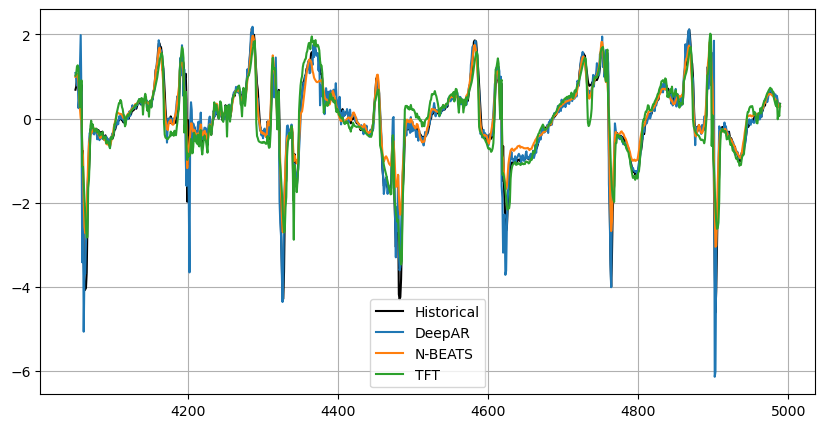

In [15]:
plt.plot(final_df['Historical'], color = 'black', label = 'Historical')
plt.plot(final_df['Predictions DeepAR'], label = 'DeepAR')
plt.plot(final_df['Predictions NBEATS'], label = 'N-BEATS')
plt.plot(final_df['Predictions TFT'], label = 'TFT')
plt.grid(visible = True)
plt.legend(loc = 'best')
plt.show()

In [17]:
pd.concat([
    metrics_deepar,
    metrics_nbeats,
    metrics_tft
]).sort_values('R2', ascending = False)

,MAPE,SMAPE,R2,MAE,RMSE,MBE,Pearson,pval,Model
0,1.964963,43.629644,0.888429,0.190168,0.332594,-0.073015,0.965842,0.0,NBEATS
0,1.483493,37.967594,0.869594,0.166521,0.359572,-0.004706,0.935154,0.0,DeepAR
0,4.340531,52.284640,0.851285,0.229795,0.383986,-0.003792,0.922763,0.0,TFT
